In [1]:
import sys; sys.path.append('..')

import os
from typing import List

import torch
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import skimage
from PIL import Image
from torchvision import transforms

from convert_weights import(
    convert_weights,
    load_state_from_depricated_model,
    get_old_model,
    get_new_model
)

In [2]:
src_w_path = "..\\weights\\depricated_weights\\residual_decoder__upsample__B_2__6_epochs_2023-06-08T12_35.pt"
dest_w_path = "..\\weights\\full__resnet_autoencoder__512x16x16__upsample__B_2__6_epochs_2023-06-08T12_35.pt"

In [3]:
convert_weights(src_w_path, dest_w_path)

In [4]:
def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result


def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)

In [5]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)


inference_data_transform = transforms.Compose([
        transforms.ToTensor(),
        imagenet_normalize
    ])

In [6]:
def img_path_to_model_input(img_path: str, inference_data_transform = inference_data_transform):
    image = Image.fromarray(skimage.io.imread(img_path))
    image = (image)
    image = inference_data_transform(image)
    return image

In [7]:
def show_dir_imgs(dir_name: str, model, data_transform,
                  scale_factor: int = 3, device = None) -> None:
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    fig, axs = plt.subplots(2, 3, dpi=80)
    plt.axis('off')


    for i, img_name in enumerate(os.listdir(dir_name)):
        image = img_path_to_model_input(os.path.join(dir_name, img_name))

        orig_img_on_device = image.unsqueeze(0).to(device)
        decoded_img = model(
            orig_img_on_device).cpu().detach().squeeze(0)
        
        axs[0, i].imshow(denormalize_imagenet(image).numpy().transpose(1,2,0))
        axs[1, i].imshow(denormalize_imagenet(decoded_img).permute(1, 2, 0))

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_size_inches(fig.get_size_inches()*scale_factor)  # double the default size

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


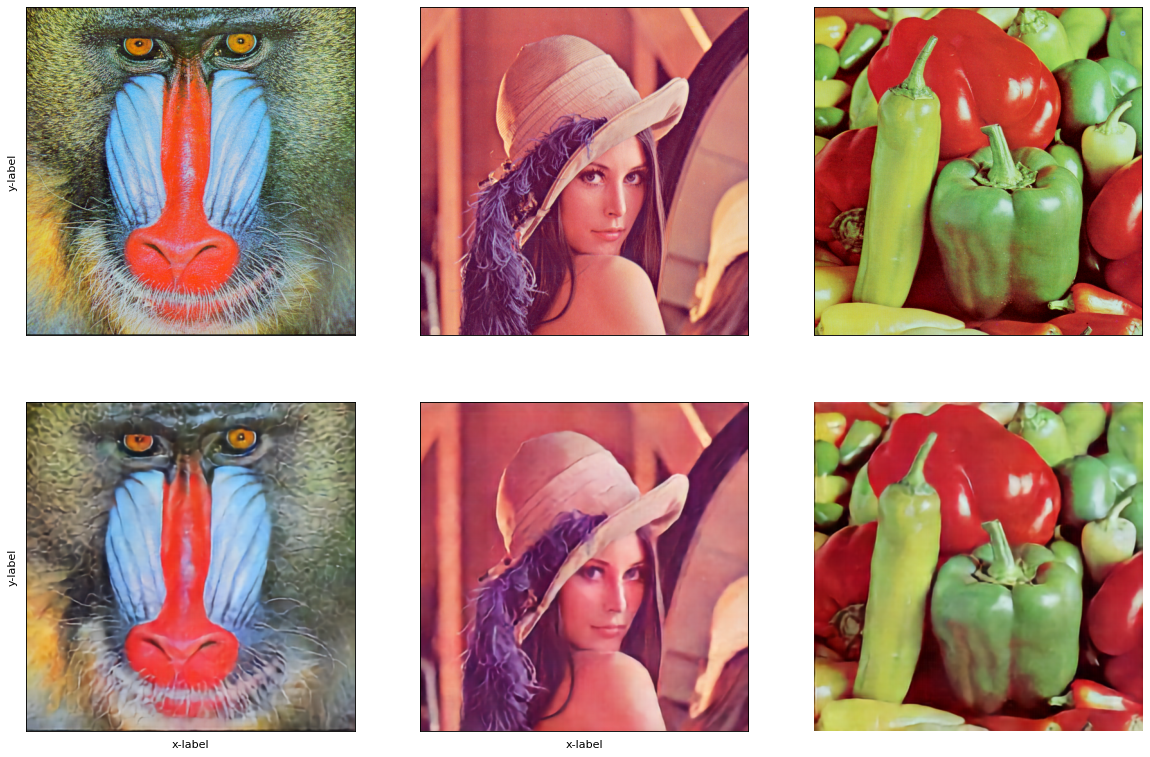

In [8]:
old_model = get_old_model(src_w_path, B = 2)
old_model.eval()
lab_imgs_path = "..\\compression-lab-imgs"

show_dir_imgs(lab_imgs_path, old_model, inference_data_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


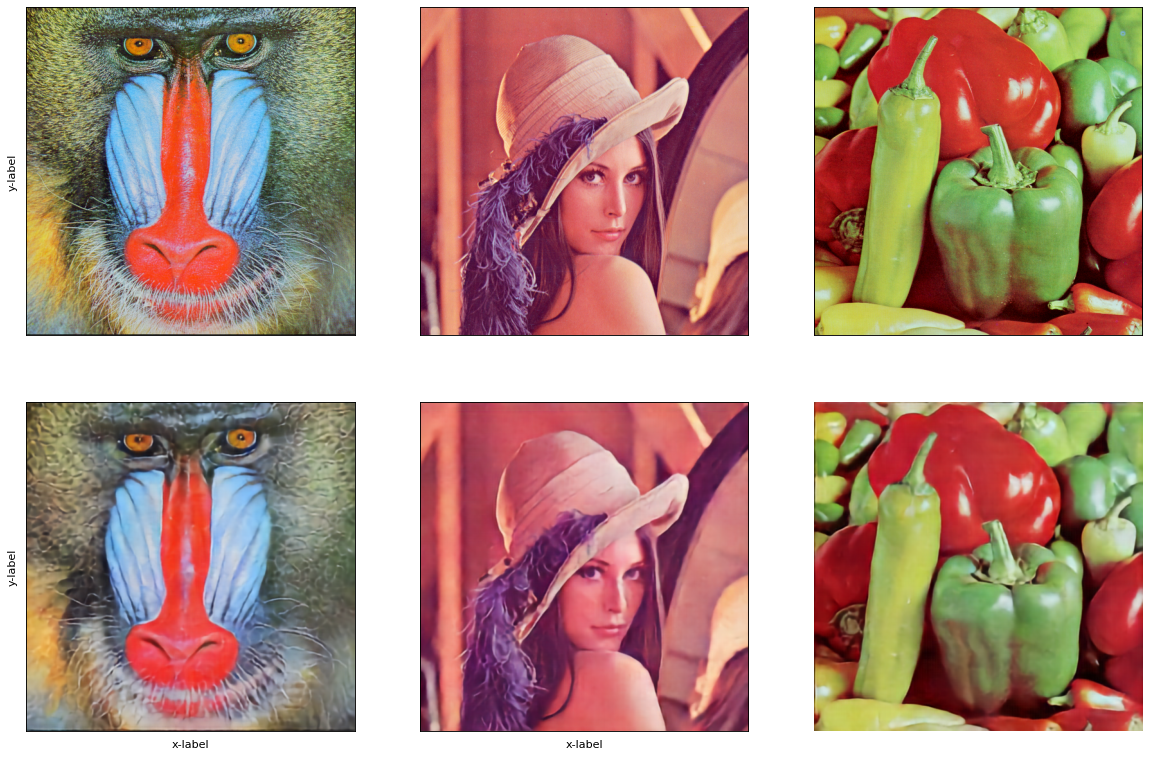

In [9]:
new_model = get_new_model(B = 2)
new_model.eval()
lab_imgs_path = "..\\compression-lab-imgs"

# load_state_from_depricated_model(old_model, new_model)
new_model.load_state_dict(torch.load(dest_w_path, map_location=torch.device('cpu')))

show_dir_imgs(lab_imgs_path, new_model, inference_data_transform)